# Preprocess HBEC IFN data

For now, isolate the Type I interferons

In [1]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data_path = '/data_volume/ifn_hbec/'

In [3]:
%matplotlib inline

### Read the data

In [4]:
adata = sc.read(data_path + 'HBEC_condition_assigned.h5ad')

In [6]:
adata.obs['donor'] = adata.obs['condition'].apply(lambda x: x.split('_')[0])
adata.obs['stim'] = adata.obs['condition'].apply(lambda x: x.split('_')[1])
adata.obs['time'] = adata.obs['condition'].apply(lambda x: x.split('_')[2] if 'control' not in x else 0)

Trying to set attribute `.obs` of view, copying.


In [7]:
adata.shape

(78660, 36721)

In [8]:
# adata = adata[(adata.obs['stim'].isin(['control', 'alpha', 'beta']))]

### Slice out mRNA from ADT

In [9]:
adt_adata = adata[:, adata.var.query('feature_types == "Antibody Capture" & ~gene_ids.str.contains("hash").values').index].copy()
rna_adata = adata[:, adata.var.query('feature_types != "Antibody Capture"').index].copy()

In [10]:
rna_adata.shape

(78660, 36601)

In [11]:
rna_adata.obs.stim.value_counts()/rna_adata.shape[0]

beta       0.252949
alpha      0.248958
gamma      0.238139
lambda     0.222082
control    0.037872
Name: stim, dtype: float64

### Process RNA data

In [12]:
sc.pp.filter_cells(rna_adata, min_genes=50)
# sc.pp.filter_genes(rna_adata, min_cells=500)

In [13]:
rna_adata.var['mt'] = rna_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(rna_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [14]:
# rna_adata = rna_adata[rna_adata.obs.n_genes_by_counts < 2500, :]
rna_adata = rna_adata[rna_adata.obs.pct_counts_mt < 20, :]

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [15]:
rna_adata.shape

(69252, 36601)

In [16]:
rna_adata.obs.stim.value_counts()/rna_adata.shape[0]

beta       0.262130
alpha      0.260585
gamma      0.233149
lambda     0.210030
control    0.034107
Name: stim, dtype: float64

In [17]:
rna_adata_counts = rna_adata.copy()

In [18]:
sc.pp.normalize_total(rna_adata, target_sum=1e4)

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [19]:
sc.pp.log1p(rna_adata)

In [20]:
rna_adata.raw = rna_adata

In [22]:
sc.pp.highly_variable_genes(rna_adata, min_mean=0.01, max_mean=3, min_disp=0.5, batch_key='donor')

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [23]:
rna_adata = rna_adata[:, rna_adata.var.highly_variable & ~rna_adata.var.mt]

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [31]:
rna_adata.raw.shape

(69252, 36601)

In [32]:
sc.pp.regress_out(rna_adata, ['total_counts', 'pct_counts_mt'])

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


In [33]:
# sc.pp.combat(rna_adata, key='donor')

In [34]:
sc.pp.scale(rna_adata, max_value=10)

In [35]:
sc.tl.pca(rna_adata, svd_solver='arpack')

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [36]:
sc.pp.neighbors(rna_adata, n_neighbors=30, n_pcs=40)


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/envs/single_cell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../

In [37]:
sc.tl.umap(rna_adata)

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


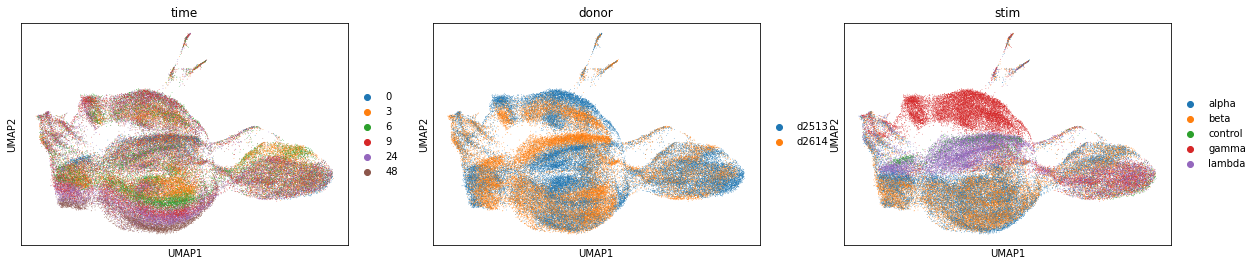

In [38]:
sc.pl.umap(rna_adata, color=['time', 'donor', 'stim'])

### Clustering

In [42]:
sc.tl.leiden(rna_adata, resolution=1.5)

In [43]:
rna_adata.obs.head(5)

,BEST.GUESS,DROPLET.TYPE,NUM.SNPS,batch,HTO_classification,condition,donor,stim,time,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACCCAAGGAAGTAG-1,donor1,SNG,836,0,hash-10,d2513_lambda_9,d2513,lambda,9,2725,2725,5949.0,682.0,11.464111,2
AAACCCAAGGGACTGT-1,donor1,SNG,447,0,hash-3,d2513_alpha_24,d2513,alpha,24,1399,1399,3602.0,199.0,5.524708,17
AAACCCACAATCTGCA-1,donor0,SNG,537,0,hash-1,d2614_alpha_3,d2614,alpha,3,1878,1878,4664.0,252.0,5.403088,1
AAACCCACACGTTCGG-1,donor0,SNG,505,0,hash-1,d2614_alpha_3,d2614,alpha,3,1690,1690,4052.0,291.0,7.181639,1
AAACCCACAGAACTAA-1,donor0,SNG,468,0,hash-8,d2614_gamma_48,d2614,gamma,48,1796,1796,3813.0,363.0,9.520062,0


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


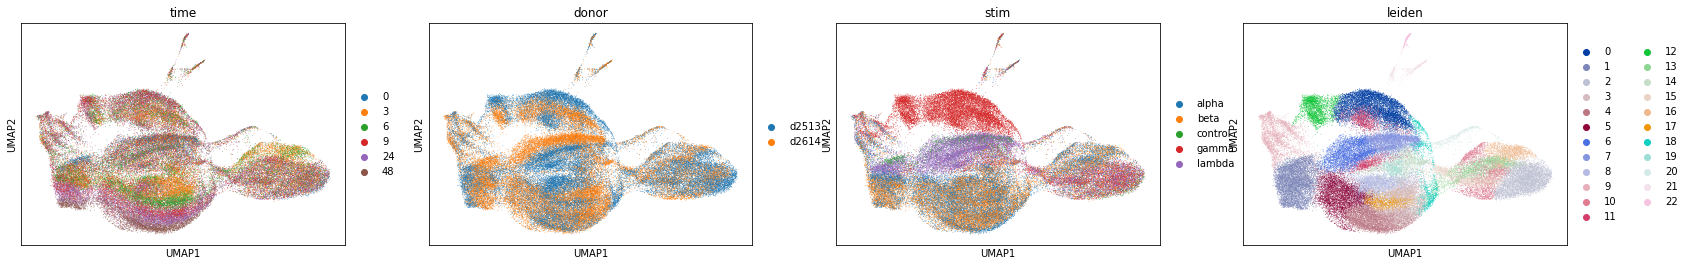

In [44]:
sc.pl.umap(rna_adata, color=['time', 'donor', 'stim', 'leiden'])

### Identify cell types using marker genes

In [60]:
import pandas as pd

In [85]:
marker_genes = ['KRT5', 'DAPL1', 'TP63', 'KRT4', 'KRT13', 'SCGB1A1','KRT15', 'LYPD2','FOXJ1', 'CCDC113','CCDC153',
                'MLF1', 'LZTFL1','CHGA', 'ASCL1', 'POU2F3', 'AVIL', 'GNAT3','FOXI1', 'CFTR', 'ASCL3', 'MUC5AC', 'MUC5B', 'GP2','SPDEF']


In [86]:
marker_matrix = rna_adata.raw[:, marker_genes].X

In [92]:
marker_df = pd.DataFrame(marker_matrix.toarray(), columns=marker_genes)
marker_df['cluster'] = rna_adata.obs.leiden.values
marker_df = marker_df.groupby('cluster')[marker_genes].mean()
marker_df[marker_genes] = marker_df[marker_genes]/marker_df[marker_genes].max(axis=0)

In [101]:
adt_marker_df = pd.DataFrame(adt_adata[rna_adata.obs.index, -11:].X.toarray(), columns=adt_adata.var.tail(11).index)
adt_marker_df['cluster'] = rna_adata.obs.leiden.values
adt_marker_df = adt_marker_df.groupby('cluster').mean()
# adt_marker_df = adt_marker_df/adt_marker_df.max(axis=0)

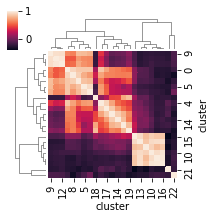

In [108]:
cg = sns.clustermap(marker_df.T.corr(), figsize=(3,3))

<AxesSubplot:ylabel='cluster'>

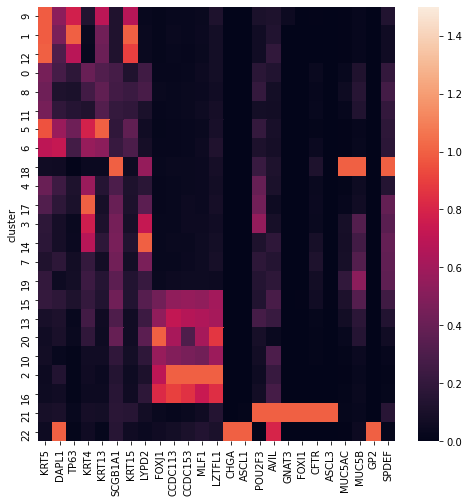

In [96]:
order = cg.dendrogram_row.reordered_ind
plt.figure(figsize=(8,8))
sns.heatmap(marker_df.iloc[order, :], vmax=1.5)

In [106]:
cell_type_converter = \
    ['basal' for i in range(3)] + \
    ['basal/club' for i in range(5)] + \
    ['goblet'] + \
    ['club' for i in range(6)] + \
    ['ciliated' for i in range(6)] + \
    ['ionocyte/tuft'] + ['neuroendo']
cell_type_converter = dict(zip(order, cell_type_converter))

In [109]:
rna_adata.obs['cell_type'] = rna_adata.obs['leiden'].apply(lambda x: cell_type_converter[int(x)])

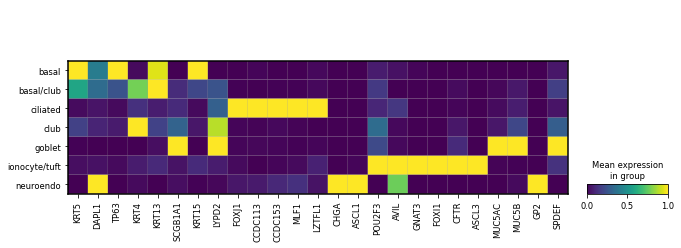

In [116]:
sc.pl.matrixplot(rna_adata, marker_genes, groupby='cell_type', standard_scale='var')

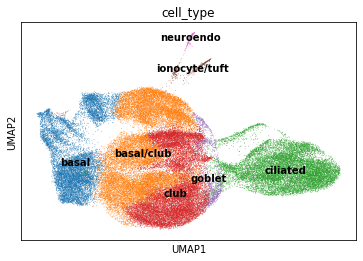

In [119]:
sc.pl.umap(rna_adata, color='cell_type', legend_loc='on data')

### Save the objects

In [120]:
rna_adata.write(data_path + 'HBEC_type_I_processed.h5ad')

In [121]:
rna_adata_counts.obs = rna_adata.obs
rna_adata_counts.write(data_path + 'HBEC_type_I_filtered_counts.h5ad')